In [1]:
from adjustText import adjust_text
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import kendalltau, pearsonr
import geopandas as gpd
import libpysal
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns

from epitools import get_data

In [2]:
gdf = gpd.read_file(f"geo_shapes/France_department.gpkg")
gdf.head()

,department_id,department,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.79458 46.21832, ..."
1,02,Aisne,"POLYGON ((4.04797 49.40564, 4.03991 49.39740, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.04907 46.75808, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.69209 44.18648, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.29922 45.10855, ..."


In [3]:
asd = pd.read_csv(f"data_output/France/{2002}_divisiveness_department_id_nv_first_round.csv.gz")
asd[asd["department_id"] == "31"].sort_values("value", ascending=False)

,candidate,value,weight,type,department_id
502,NOEL MAMERE,0.116190,0.083680,Between,31
497,FRANCOIS BAYROU,0.116041,0.077668,Between,31
500,JEAN-PIERRE CHEVENEMENT,0.115948,0.070634,Between,31
496,ARLETTE LAGUILLER,0.115545,0.067393,Between,31
503,OLIVIER BESANCENOT,0.115056,0.056657,Between,31
498,JACQUES CHIRAC,0.111211,0.184494,Between,31
499,JEAN-MARIE LE PEN,0.109810,0.201560,Between,31
501,LIONEL JOSPIN,0.104248,0.257914,Between,31
507,JEAN-MARIE LE PEN,0.005613,0.201560,Within,31
509,LIONEL JOSPIN,0.005380,0.257914,Within,31


In [4]:
output = []
method = "nv"
country_output = []

for year in [2002, 2007, 2012, 2017, 2022]:
    print(year)
    df_dv = get_data(
        country="France",
        year=year,
        election="first_round",
        aggregation="department_id",
        method="nv"
    )
    
    output.append(df_dv)
    
df_dv = pd.concat(output, ignore_index=True)
df_dv["department_id"] = df_dv["department_id"].astype(str).str.zfill(2)
df_dv = df_dv[~df_dv["department_id"].isin(["2A", "2B"])]
df_dv.head()

2002
2007
2012
2017
2022


,department_id,epi,epi_between,epi_within,year
0,01,0.930960,0.902538,0.028422,2002
1,02,0.927785,0.890860,0.036926,2002
2,03,0.938693,0.904055,0.034638,2002
3,04,0.946616,0.909911,0.036705,2002
4,05,0.952332,0.915178,0.037153,2002


In [5]:
df_dv["polarization"] = df_dv["epi_between"] / df_dv["epi_within"]
df_dv

,department_id,epi,epi_between,epi_within,year,polarization
0,01,0.930960,0.902538,0.028422,2002,31.755255
1,02,0.927785,0.890860,0.036926,2002,24.125717
2,03,0.938693,0.904055,0.034638,2002,26.100055
3,04,0.946616,0.909911,0.036705,2002,24.789677
4,05,0.952332,0.915178,0.037153,2002,24.632386
...,...,...,...,...,...,...
518,ZP,0.911296,0.870063,0.041233,2022,21.100958
519,ZS,0.895420,0.887532,0.007888,2022,112.513407
520,ZW,0.884796,0.884796,0.000000,2022,inf
521,ZX,0.912011,0.885602,0.026409,2022,33.534307


In [6]:
df_dv.value_counts("year")

year
2012    106
2017    105
2022    105
2007     99
2002     98
dtype: int64

In [7]:
# df_dv.sort_values("year")

In [8]:
dd = df_dv.pivot_table(index="department_id", columns="year", values="epi").reset_index()
dd.columns = ["department_id", 2002, 2007, 2012, 2017, 2022]
years = list(df_dv.year.unique())
corr_year = dd.values

In [9]:
# dd

In [10]:
df_country = pd.DataFrame(country_output)
df_country["department_id"] = "FR"
df_country.head()

,department_id


In [11]:
df_dv.max()

department_id          ZZ
epi              0.952332
epi_between      0.915178
epi_within       0.070511
year                 2022
polarization          inf
dtype: object

In [12]:
df_dv = df_dv[~df_dv["department_id"].str.contains("Z")]
df_dv["alternative"] = 1 - df_dv["epi_within"]/df_dv["epi"] 

C:\Users\cnava\AppData\Local\Temp\ipykernel_35136\3899601153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dv["alternative"] = 1 - df_dv["epi_within"]/df_dv["epi"]


In [13]:
df_dv[df_dv["epi_within"] == 0]

,department_id,epi,epi_between,epi_within,year,polarization,alternative


C:\Users\cnava\AppData\Local\Temp\ipykernel_35136\4032417415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dv["vl"] = pd.qcut(df_dv[measure_name].copy(), 7)


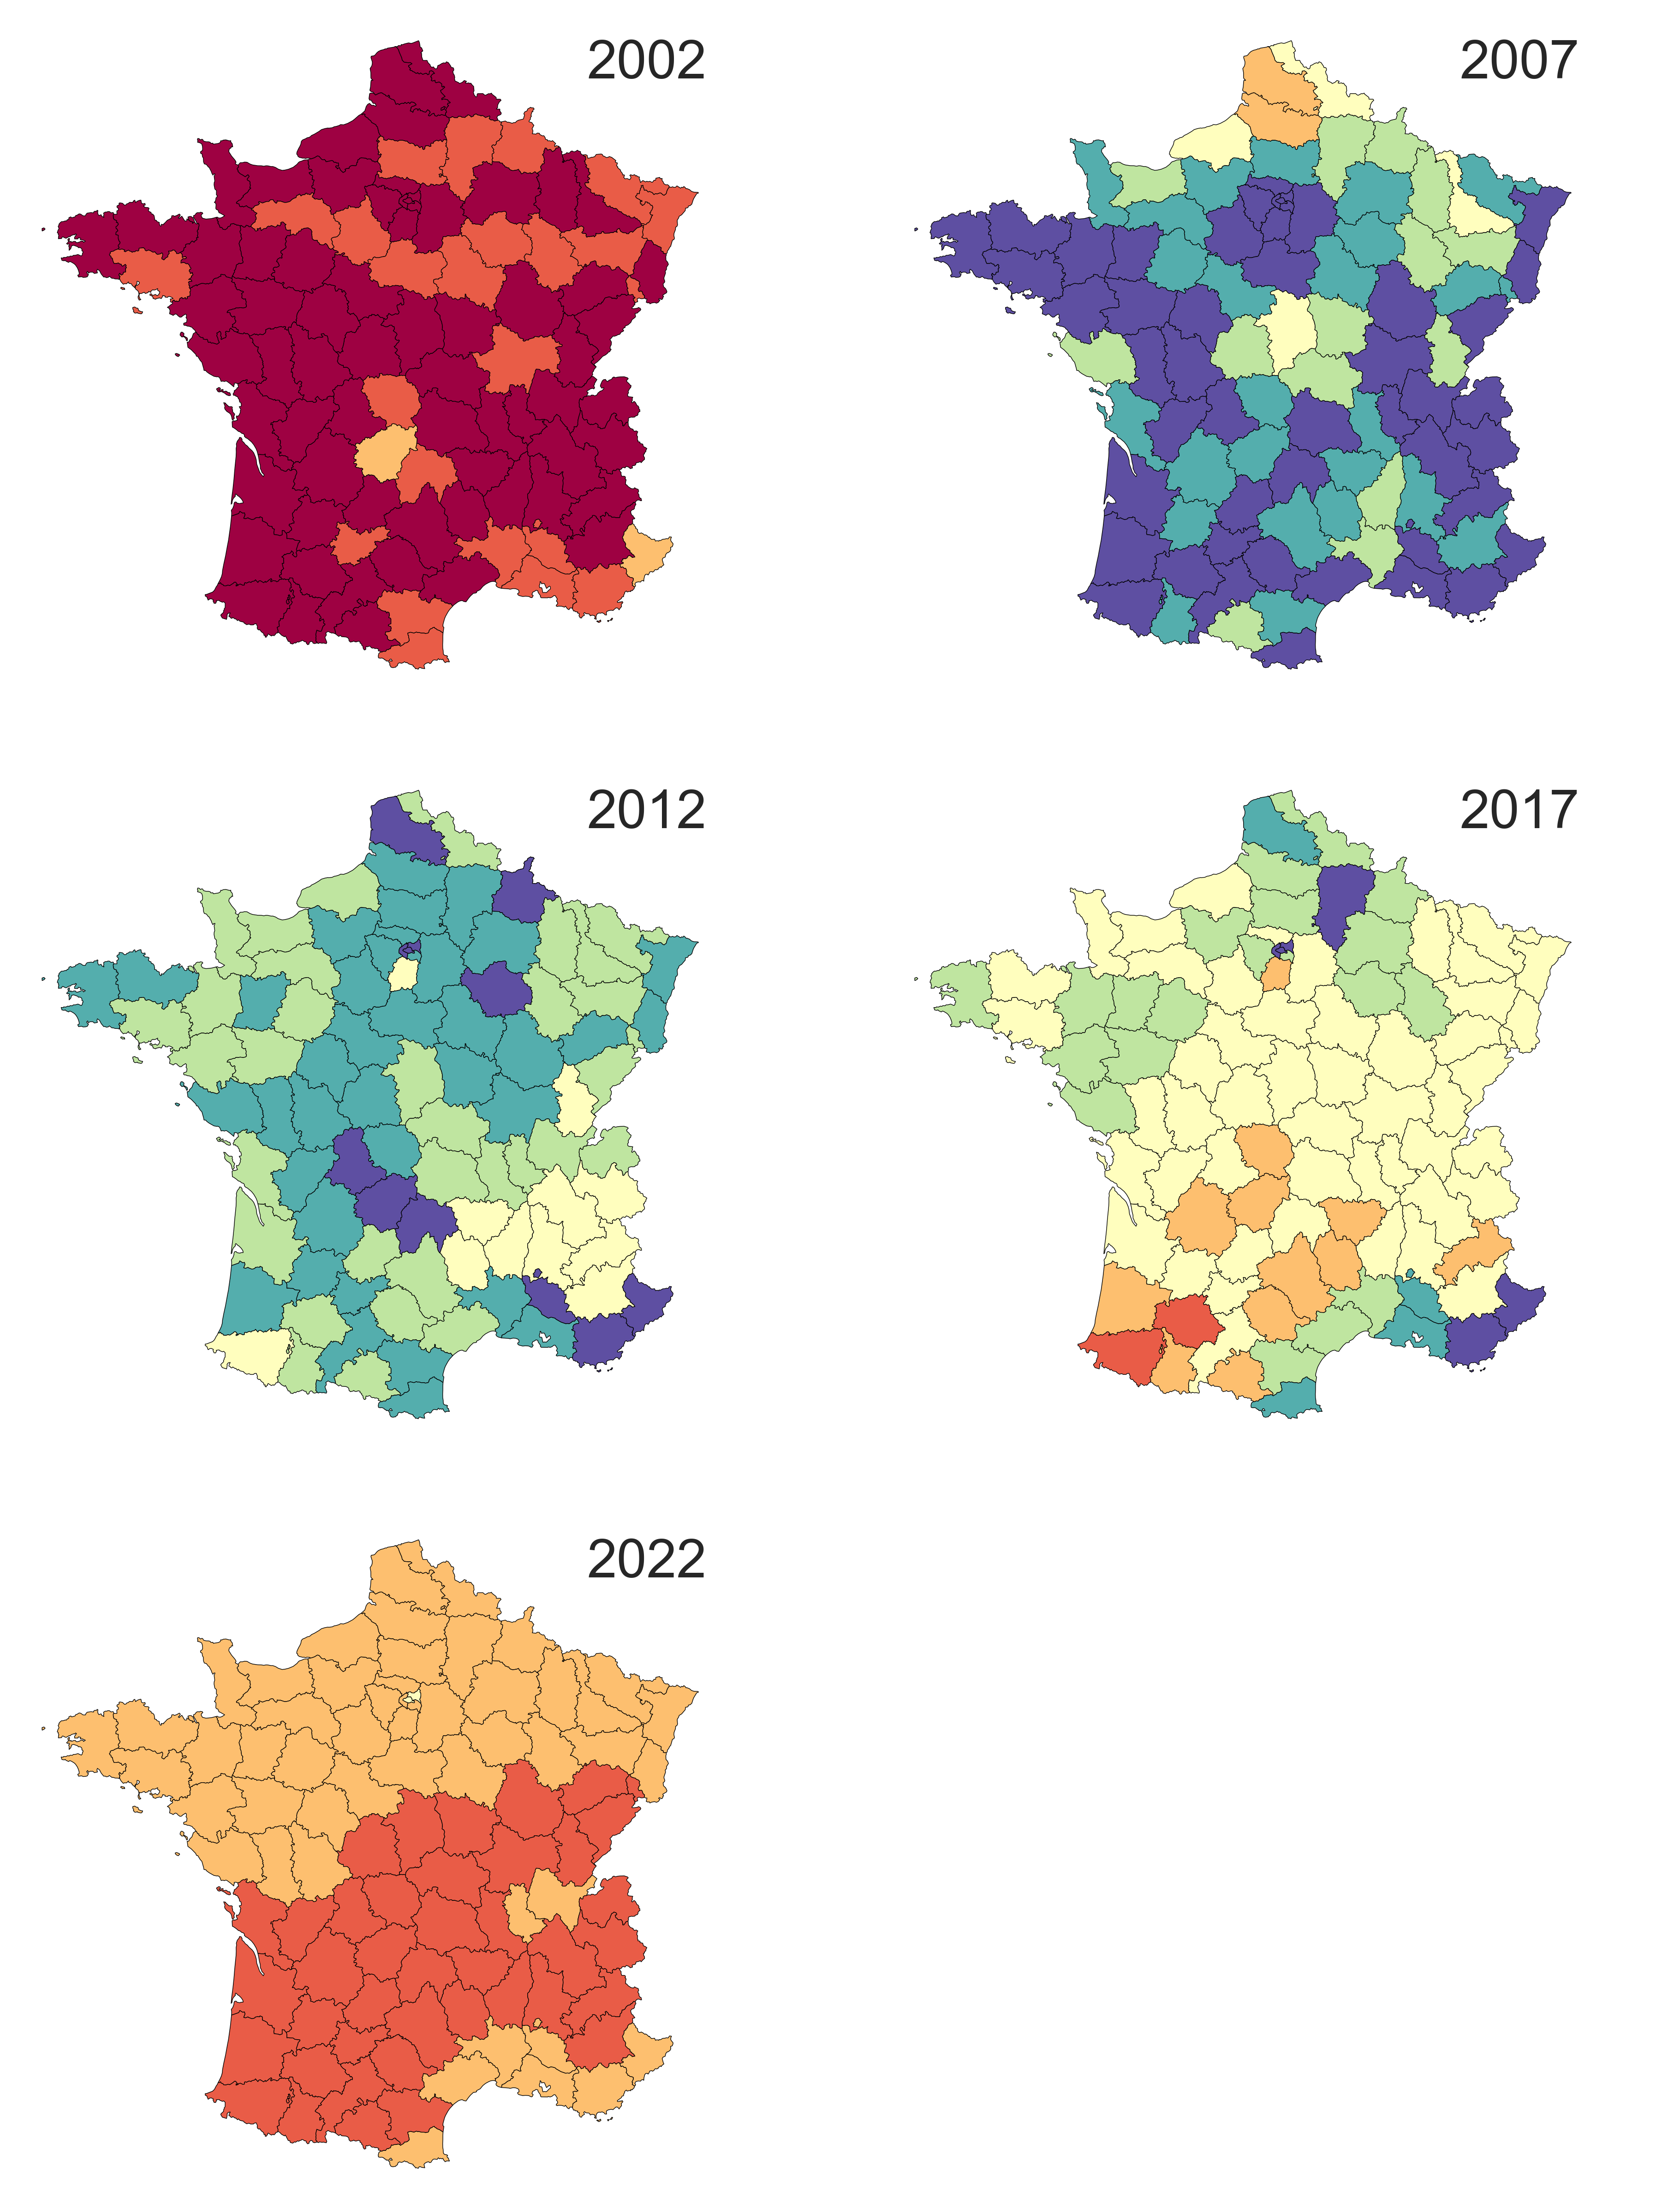

In [14]:
sns.set(font_scale=3.5, style="white")
measure_name = "epi"

df_dv["vl"] = pd.qcut(df_dv[measure_name].copy(), 7)
cmap = {"epi_between": "YlGn", "epi_within": "YlGnBu", "epi": "Spectral_r"}

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 25), dpi=200)
def set_corr(corr, _):
    corr = round(corr, 3)
    if _ < 0.01:
        return f"ρ={corr}***"
    elif _ < 0.05:
        return f"ρ={corr}**"
    elif _ < 0.1:
        return f"ρ={corr}*"
    return f"ρ={corr}"

for idx, year in enumerate([2002, 2007, 2012, 2017, 2022]):
    data_tmp = df_dv[df_dv["year"] == year]
    data_tmp = pd.merge(data_tmp, gdf, on="department_id")
    ax = axs[int(idx/2), idx%2]
    W = libpysal.weights.Queen.from_dataframe(data_tmp)
    W.transform = "r"
    data_tmp["sp_value"] = libpysal.weights.lag_spatial(W, data_tmp[measure_name])

    data_tmp = gpd.GeoDataFrame(data_tmp).dropna()

    data_tmp.plot(
        # column=measure_name,
        column="vl",
        edgecolor="black",
        # vmin=df_dv[measure_name].min(),
        # vmax=df_dv[measure_name].max(),
        lw=0.5,
        ax=ax, 
        cmap=cmap[measure_name],
        legend=False, 
        legend_kwds=dict(
            shrink=0.25
        )
    )

    corr, _ = pearsonr(data_tmp[measure_name], data_tmp["sp_value"])
    # ax.text(0.05, 0.9, set_corr(corr, _), color="green", transform=ax.transAxes)

    # if year > 2002:
    #     value = corr_year[years.index(year - 5), years.index(year)]
    #     tmp = dd[[year - 5, year]].copy().dropna()
    #     corr, _ = pearsonr(tmp[year - 5], tmp[year])
    #     ax.text(0.05, 0.97, set_corr(corr, _), color="blue", transform=ax.transAxes)

    ax.axis("off")
    ax.text(0.8, 0.9, year, transform=ax.transAxes)

axs[2, 1].axis("off")

fig.tight_layout()

In [15]:
categories = df_dv["vl"].sort_values().unique()

for idx, vl in enumerate(categories):
    if idx == 0:
        print(f"<{vl.right}")
    elif idx == len(categories) - 1:
        print(f">{vl.left}")
    else:
        print(f"{vl.left}-{vl.right}")

<0.884
0.884-0.89
0.89-0.896
0.896-0.903
0.903-0.913
0.913-0.93
>0.93


In [16]:
df_inequality = pd.read_excel(
    "https://www.insee.fr/fr/statistiques/fichier/5371235/RPM2021-F18.xlsx",
    sheet_name="figure 2",
    header=2
).head(101)
df_inequality = df_inequality.rename(columns={"Code": "department_id", "Taux de pauvreté (en\xa0%)": "poverty_rate"})
df_inequality.head()

,department_id,Département,poverty_rate
0,01,Ain,10.3
1,02,Aisne,18.4
2,03,Allier,15.5
3,04,Alpes-de-Haute-Provence,16.8
4,05,Hautes-Alpes,13.9


In [17]:
df_location = pd.read_csv(f"data_output/France/2022_first_round_location.csv.gz")
df_location = df_location.groupby(["department_id"]).agg({"electors": "sum", "abstentions": "sum"}).reset_index()
df_location["participation"] = 1 - df_location["abstentions"] / df_location["electors"]
df_location.head()

C:\Users\cnava\AppData\Local\Temp\ipykernel_35136\954207689.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_location = pd.read_csv(f"data_output/France/2022_first_round_location.csv.gz")


,department_id,electors,abstentions,participation
0,01,438109,97541,0.777359
1,02,373544,101089,0.729379
2,03,249991,58497,0.766004
3,04,128075,29290,0.771306
4,05,113519,25357,0.776628


In [18]:
df_location2 = pd.read_csv(f"data_output/France/2022_runoff_location.csv.gz")
df_location2 = df_location2.groupby(["department_id"]).agg({"electors": "sum", "abstentions": "sum"}).reset_index()
df_location2["participation2"] = 1 - df_location2["abstentions"] / df_location2["electors"]
df_location2.head()

C:\Users\cnava\AppData\Local\Temp\ipykernel_35136\1908648492.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_location2 = pd.read_csv(f"data_output/France/2022_runoff_location.csv.gz")


,department_id,electors,abstentions,participation2
0,01,438250,109568,0.749987
1,02,373621,97965,0.737796
2,03,249954,62311,0.750710
3,04,128077,31907,0.750876
4,05,113540,27296,0.759591


In [19]:
df_poverty = pd.read_excel("data_external/France/poverty_2017.xlsx", sheet_name="Figure 3", header=2).dropna()
df_poverty["Taux de pauvreté"] = df_poverty["Taux de pauvreté"].astype(float) / 100
df_poverty = df_poverty.rename(columns={"Code": "department_id", "Département": "department", "Taux de pauvreté": "poverty_rate"})
df_poverty.head()

,department_id,department,poverty_rate
0,74,Haute-Savoie,0.091
1,85,Vendée,0.093
2,78,Yvelines,0.094
3,73,Savoie,0.098
4,44,Loire-Atlantique,0.101


In [20]:
dd = pd.merge(df_dv[df_dv["year"] == 2022], df_poverty, on="department_id")
dd = pd.merge(dd, df_location[["department_id", "participation"]], on="department_id")
dd = pd.merge(dd, df_location2[["department_id", "participation2"]], on="department_id")

dd = dd[~dd["department_id"].isin(["2A", "2B"])]
# dd = dd[["value", "poverty_rate", "participation", "participation2"]]


In [21]:
pd.read_csv("data_external/France/Insee/meta_FILO2019_DEC_DEP.csv", encoding="utf-8", delimiter=";").head()

FileNotFoundError: [Errno 2] No such file or directory: 'data_external/France/Insee/meta_FILO2019_DEC_DEP.csv'

In [ ]:
df_stats = pd.read_csv("data_external/France/Insee/FILO2019_DEC_DEP.csv", encoding="utf-8", delimiter=";")
df_stats = df_stats.rename(columns={"CODGEO": "department_id", "GI19": "gini"})
df_stats

,department_id,NBMEN19,NBPERS19,NBUC19,PMIMP19,Q119,Q219,Q319,Q3_Q1,D119,...,OPR5D919,OPR5RD,OPR5S80S2019,OPR5GI19,OPR5PACT19,OPR5PTSA19,OPR5PCHO19,OPR5PBEN19,OPR5PPEN19,OPR5PAUT19
0,01,265876,632800,425987.3,59.6,16150,23250,32800,16650,9380,...,104710,NaN,6337.5,0.692,18.0,16.0,0.9,1.1,11.5,70.5
1,02,223756,513384,351009.0,49.5,12120,19030,26170,14050,5700,...,97100,3883.8,141.9,0.568,15.8,11.5,0.8,3.5,16.6,67.6
2,03,159016,326409,233659.1,49.0,13460,19720,26590,13130,6840,...,84990,NaN,28446.5,0.641,16.1,13.8,0.9,1.4,16.4,67.5
3,04,74172,154335,109862.7,51.5,13370,20140,28160,14800,7120,...,68940,67.2,61.2,0.634,11.1,8.8,0.8,1.5,8.9,80.0
4,05,64721,134710,95836.5,54.2,14350,20560,27930,13580,8610,...,83210,56.0,36.1,0.503,18.6,13.8,1.5,3.3,15.0,66.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,93,601846,1600460,1029621.7,54.9,8920,16410,26270,17360,3880,...,81780,NaN,1173.4,0.647,20.9,17.3,1.8,1.8,9.6,69.5
94,94,565806,1363385,911777.8,67.7,13440,23280,35680,22240,6640,...,142690,832.8,109.0,0.604,18.3,15.7,1.1,1.5,10.8,70.9
95,95,466919,1256247,807878.2,66.0,13070,22030,32110,19040,6740,...,125140,1017.4,101.4,0.595,20.1,17.0,1.5,1.6,10.9,69.0
96,972,149609,324588,227771.5,39.2,8110,16690,27350,19240,1540,...,73020,NaN,NaN,0.819,19.0,15.5,0.9,2.6,8.3,72.7


In [ ]:
# https://www.insee.fr/fr/statistiques/2012717
df_income = pd.read_excel(
    "https://www.insee.fr/fr/statistiques/fichier/2012717/TCRD_022.xlsx",
    header=4
)
df_income = df_income.rename(columns={
    "Unnamed: 0": "department_id",
    "Unnamed: 1": "department",
    "Nombre": "number_households",
    "Part des ménages fiscaux imposés (en %)": "fraction_taxed",
    "Médiane": "median_household_income"
}).dropna()

In [ ]:
# https://www.insee.fr/fr/statistiques/4806684
df_rurality = pd.read_excel(
    "https://www.insee.fr/fr/statistiques/fichier/4806684/if210.xlsx",
    sheet_name="Figure 2"
).dropna()
df_rurality = df_rurality.rename(columns={
    "Figure 2 - Part de la population française en 2017 vivant dans une unité urbaine": "department_id",
    "Unnamed: 1": "department",
    "Unnamed: 2": "urban"
})
df_rurality["rurality"] = 1 - df_rurality["urban"]/100
df_rurality.head()

,department_id,department,urban,rurality
1,01,Ain,67,0.33
2,02,Aisne,53.2,0.468
3,03,Allier,58.3,0.417
4,04,Alpes-de-Haute-Provence,61.9,0.381
5,05,Hautes-Alpes,59.5,0.405


In [ ]:
year = 2022

data = pd.merge(
    df_poverty,
    df_dv[df_dv["year"] == year],
    on="department_id"
)

data = pd.merge(
    data,
    df_stats,
    on="department_id"
)

data = pd.merge(
    data,
    df_income,
    on="department_id"
)

data = pd.merge(
    data,
    df_rurality,
    on="department_id"
)
data.head()

,department_id,department_x,poverty_rate,value,year,NBMEN19,NBPERS19,NBUC19,PMIMP19,Q119,...,OPR5PAUT19,department_y,number_households,fraction_taxed,median_household_income,1er décile (D1),9e décile (D9),department,urban,rurality
0,74,Haute-Savoie,0.091,11.148693,2022,349755,798144,545337.2,62.5,18250,...,70.4,Haute-Savoie,348025.0,62.5,26540.0,13450.0,56930.0,Haute-Savoie,86.4,0.136
1,85,Vendée,0.093,11.062862,2022,307017,691931,477643.5,53.8,15950,...,70.7,Vendée,306763.0,53.8,21550.0,13490.0,33970.0,Vendée,67.7,0.323
2,78,Yvelines,0.094,11.163978,2022,580809,1462552,965243.2,74.5,17920,...,70.2,Yvelines,579650.0,74.5,26970.0,13220.0,51570.0,Yvelines,93,0.07
3,73,Savoie,0.098,11.184412,2022,193293,427682,296856.3,63.5,16460,...,69.2,Savoie,193116.0,63.5,23210.0,13110.0,39150.0,Savoie,77.2,0.228
4,44,Loire-Atlantique,0.101,11.152132,2022,618976,1407557,963483.0,59.5,16190,...,71.5,Loire-Atlantique,618356.0,59.5,22910.0,13110.0,38310.0,Loire-Atlantique,84.6,0.154


In [ ]:
VOTES_POLLING = 100
RATE_THRESHOLD = 0.02
output = []

method = "nv"
for country, year, geography in [
    ("France", 2002, "department_id"),
    ("France", 2007, "department_id"),
    ("France", 2012, "department_id"),
    ("France", 2017, "department_id"),
    ("France", 2022, "department_id"),
    ("United States", 2000, "county"),
    ("United States", 2004, "county"),
    ("United States", 2008, "county"),
    ("United States", 2012, "county"),
    ("United States", 2016, "state"),
    ("United States", 2020, "state"),
    # ("Chile", 2013, "province"),
    # ("Chile", 2017, "province"),
    # ("Chile", 2021, "province")
]:
    df = pd.read_csv(f"data_output/{country}/{year}_first_round.csv.gz")
    ee = df.groupby("polling_id").agg({"value": "sum"})
    values_polling = list(ee[ee["value"] > VOTES_POLLING].index.unique())
    dd = df.groupby("candidate").agg({"value": "sum"})
    dd["rate"] = dd.apply(lambda x: x/x.sum())
    values = list(dd[dd["rate"] > RATE_THRESHOLD].index.unique())

    df = df[df["polling_id"].isin(values_polling)].copy()
    df = df[df["candidate"].isin(values)].copy()

    N = len(df["candidate"].unique())
    print(N)

    value = df.groupby("candidate").agg({"rate": "std"}).sum()["rate"]

    output.append({
        "country": country,
        "year": year,
        "N": N,
        "value": value
    })

13
6
6
6
9
3
2
2
3
3
2


In [ ]:
data[["value", "poverty_rate", "gini", "median_household_income", "rurality"]].to_csv("data_regressions/factors_fra.csv", index=False)

In [ ]:
VOTES_POLLING = 100
RATE_THRESHOLD = 0.02
output = []

method = "nv"
for year in [2002, 2007, 2012, 2017, 2022]:
    df = pd.read_csv(f"data_output/France/{year}_first_round.csv.gz")
    df_location = pd.read_csv(f"data_output/France/{year}_first_round_location.csv.gz")

    for unit in ["department_id", "commune", "polling_id"]:
        if unit != "polling_id":
            df = pd.merge(df, df_location[[unit, "polling_id"]], on="polling_id")

        ee = df.groupby(unit).agg({"value": "sum"})
        values_polling = list(ee[ee["value"] > VOTES_POLLING].index.unique())
        dd = df.groupby("candidate").agg({"value": "sum"})
        dd["rate"] = dd.apply(lambda x: x/x.sum())
        values = list(dd[dd["rate"] > RATE_THRESHOLD].index.unique())

        df = df[df[unit].isin(values_polling)].copy()
        df = df[df["candidate"].isin(values)].copy()

        tt = df.groupby([unit, "candidate"]).agg({"value": "sum"})
        tt["rate"] = tt.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
        tt = tt.reset_index()
        tt = tt[[unit, "candidate", "rate"]]

        value = tt.groupby("candidate").agg({"rate": "std"}).sum()["rate"]

        output.append({
            "year": year,
            "unit": unit,
            "value": value
        })

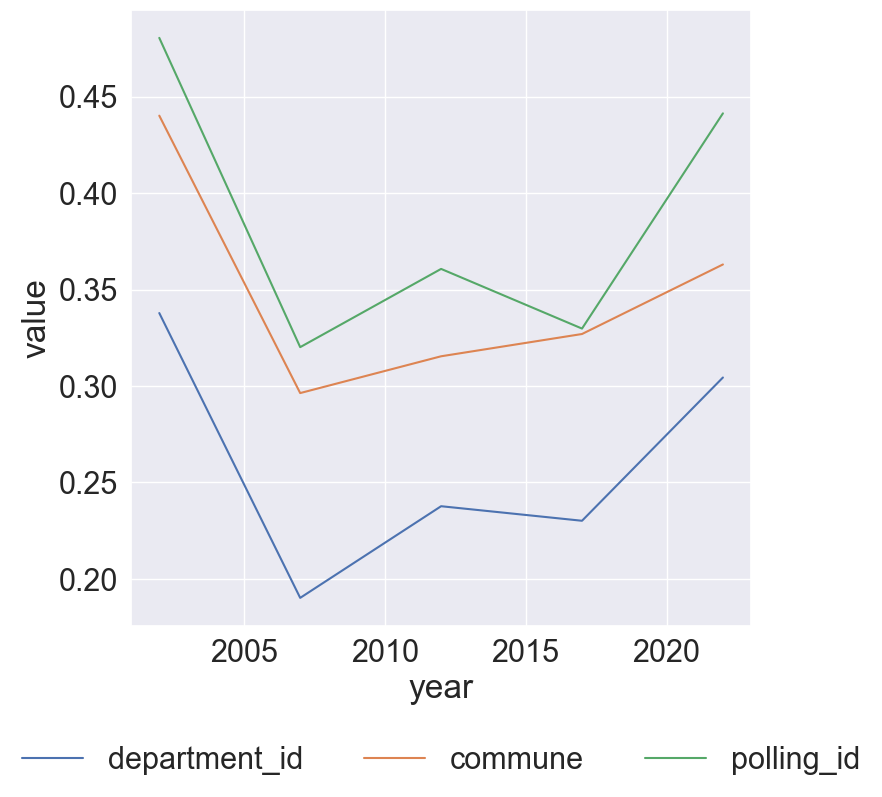

In [ ]:
asd = pd.DataFrame(output)
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(8, 8))

sns.lineplot(x="year", y="value", hue="unit", data=asd)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          frameon=False, ncol=5)

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'Poverty (%)'),
  Text(0, 1.5, 'Gini'),
  Text(0, 2.5, 'Income for consumption\n(in Euros)'),
  Text(0, 3.5, 'Rurality (%)')])

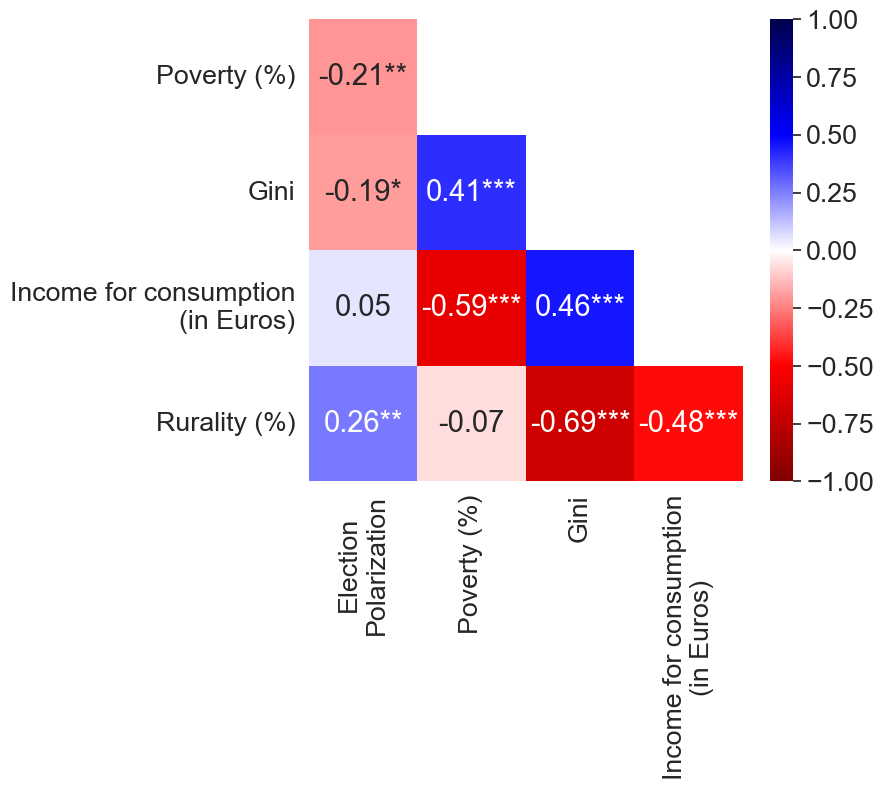

In [ ]:
def set_corr(corr, _):
    corr = round(corr, 3)
    if _ < 0.01:
        return f"{corr}***"
    elif _ < 0.05:
        return f"{corr}**"
    elif _ < 0.1:
        return f"{corr}*"
    return corr

sns.set_style("whitegrid")
sns.set(font_scale=1.75, style="whitegrid")
matplotlib.rc("axes", edgecolor="#000000")
matplotlib.rcParams['axes.grid'] = True

dd = data[["value", "poverty_rate", "gini", "median_household_income", "rurality"]] #, "household_income"
dd = dd.rename(columns={
    "value": "Election\nPolarization",
    "poverty_rate": "Poverty (%)",
    "gini": "Gini",
    "median_household_income": "Income for consumption\n(in Euros)",
    "rurality": "Rurality (%)"
})
dd["Rurality (%)"] = dd["Rurality (%)"].astype(float)

corr_m = dd.corr()
rho = dd.corr()
pval = dd.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)

p = pval.applymap(lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t]))
p = rho.round(2).astype(str) + p

p = np.tril(p.values, k=-1)

p[p==0] = np.nan
p = pd.DataFrame(p).dropna(axis=0, how="all").dropna(axis=1, how="all")

labels_m = list(corr_m)
corr_m = np.tril(corr_m.values, k=-1)

corr_m[corr_m==0] = np.nan

fig, ax = plt.subplots(figsize=(7, 6))

heatmap_data = pd.DataFrame(corr_m, index=labels_m, columns=labels_m).round(2)\
                .dropna(axis=0, how="all")\
                .dropna(axis=1, how="all")

g = sns.heatmap(heatmap_data, vmin=-1, vmax=1, annot=p, ax=ax, cmap="seismic_r", fmt="", cbar=True)

g.set_ylim(heatmap_data.shape[0], 0)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

In [ ]:
import libpysal

# create weights
W = libpysal.weights.Queen.from_dataframe(aa)

# row-normalise weights
W.transform = "r"

# create lag
aa["averaged_values"] = libpysal.weights.lag_spatial(W, aa["value"])
# aa["averaged_values_1"] = libpysal.weights.lag_spatial(W, aa["value_1"].fillna(0))

NameError: name 'aa' is not defined

In [ ]:
bb = aa.groupby(["department_id", "year"]).agg({"averaged_values": "sum"})
bb["averaged_values_1"] = bb.groupby(level=0)["averaged_values"].shift(1)
bb = bb.reset_index()
aa = pd.merge(aa, bb[["department_id", "year", "averaged_values_1"]], on=["department_id", "year"])
aa

NameError: name 'aa' is not defined

In [ ]:
output = []

for year in [2002, 2007, 2012, 2017, 2022]:
    tmp = pd.read_csv(f"data_output/France/{year}_first_round.csv.gz")
    tmp2 = pd.read_csv(f"data_output/France/{year}_first_round_location.csv.gz")

    tmp = pd.merge(tmp, tmp2[["department_id", "commune_id", "polling_id"]], on="polling_id")
    tmp["department_id"] = tmp["department_id"].astype(str).str.zfill(2)
    tmp = tmp.reset_index().dropna()
    tmp["year"] = year
    
    output.append(tmp)
    
df = pd.concat(output, ignore_index=True)
df.head()

C:\Users\cnava\AppData\Local\Temp\ipykernel_20572\678390794.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp2 = pd.read_csv(f"data_output/France/{year}_first_round_location.csv.gz")


,index,polling_id,candidate,value,rank,rate,department_id,commune_id,year
0,0,01-1-1,BRUNO MEGRET,14,11,0.032787,01,01001,2002
1,1,01-1-1,CORINNE LEPAGE,9,13,0.021077,01,01001,2002
2,2,01-1-1,DANIEL GLUCKSTEIN,1,16,0.002342,01,01001,2002
3,3,01-1-1,FRANCOIS BAYROU,30,5,0.070258,01,01001,2002
4,4,01-1-1,JACQUES CHIRAC,66,2,0.154567,01,01001,2002


In [ ]:
gdf = gpd.read_file(f"geo_shapes/France_department.gpkg")
gdf.head()